Converting bounding box values to geospatial coordinates
--

In [1]:
import cv2
import matplotlib.pyplot as plt

In [2]:
import geopandas as gpd
from shapely.geometry import box

In [3]:
import rasterio
from rasterio.plot import show
from pyproj import Transformer

In [4]:
from deepforest import main
from deepforest import get_data

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [5]:
ortho = "/ofo-share/cv-treedetection-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"

In [6]:
chm = "/ofo-share/cv-treedetection-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/chm.tif"

In [7]:
with rasterio.open(ortho) as src:
    crs = src.crs
    print(crs)


EPSG:26910


In [29]:
from rasterio.transform import xy

def pixel_to_coords(tif_path, x, y):
    with rasterio.open(tif_path) as src:      
        transform = src.transform
        x_coord, y_coord = xy(transform, y, x)    
        return x_coord, y_coord
        

In [8]:
from pyproj import Transformer

def pixel_to_latlon(tif_path, x, y):
    with rasterio.open(tif_path) as src:
        transform = src.transform
        crs = src.crs
        
        lon, lat = rasterio.transform.xy(transform, y, x)

        transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
        lon, lat = transformer.transform(lon, lat)
        return lon, lat
        

In [8]:
pixel_to_latlon(ortho, 8987, 5214)

(38.96642662765857, -120.08566215751502)

In [9]:
pixel_to_coords(ortho, 8987, 5214)

(752499.8347596796, 4317091.226490297)

In [9]:
model = main.deepforest()
model.use_release()

Reading config file: /home/apallavoor/anaconda3/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


/home/apallavoor/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/home/apallavoor/anaconda3/lib/python3.11/site-packages/deepforest/main.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.rele

In [10]:
def detect_trees_tile(path, patch_size, patch_overlap):
    predicted_raster_df = model.predict_tile(path, return_plot = False, patch_size = patch_size, patch_overlap = patch_overlap)
    img = cv2.imread(path)

    for index, row in predicted_raster_df.iterrows():
        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
    plt.imshow(img[:,:,::-1])
    return predicted_raster_df
        
    #cv2.imwrite('/ofo-share/repos-amritha/deepforest/saved_emerald_tile_predictions/emerald_'+str(patch_size)+'_'+str(patch_overlap)+'.tif', img)

You are using a CUDA device ('GRID A100X-8C') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/apallavoor/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

2773 predictions in overlapping windows, applying non-max supression
889 predictions kept after non-max suppression


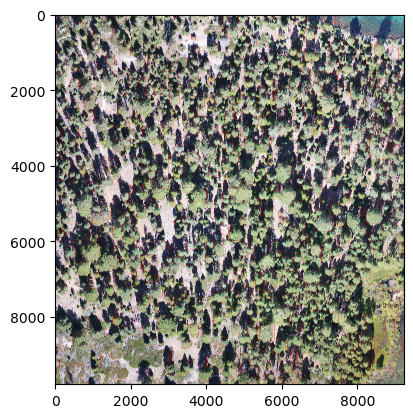

In [11]:
predicted_raster_df = detect_trees_tile(ortho, 3000, 0.5)

In [12]:
predicted_raster_df

,xmin,ymin,xmax,ymax,label,score,image_path
0,1768.0,4729.0,1968.0,4941.0,Tree,0.663390,ortho.tif
1,7748.0,2448.0,7987.0,2700.0,Tree,0.621501,ortho.tif
2,9015.0,5158.0,9229.0,5400.0,Tree,0.599605,ortho.tif
3,311.0,838.0,528.0,1065.0,Tree,0.598951,ortho.tif
4,8632.0,4682.0,8882.0,4933.0,Tree,0.596138,ortho.tif
...,...,...,...,...,...,...,...
884,8660.0,6532.0,9085.0,6927.0,Tree,0.122397,ortho.tif
885,8793.0,221.0,9203.0,624.0,Tree,0.115902,ortho.tif
886,8801.0,6043.0,9196.0,6475.0,Tree,0.113247,ortho.tif
887,8555.0,9378.0,8954.0,9764.0,Tree,0.106624,ortho.tif


In [30]:
def convert_to_coords_df(tif_path, predicted_raster_df):
    updated_df = predicted_raster_df.copy()
    
    for index, row in updated_df.iterrows():
        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        
        x_min_coord, y_min_coord = pixel_to_coords(tif_path, xmin, ymin)
        x_max_coord, y_max_coord = pixel_to_coords(tif_path, xmax, ymax)
        
        updated_df.loc[index, 'xmin'] = x_min_coord
        updated_df.loc[index, 'ymin'] = y_min_coord
        updated_df.loc[index, 'xmax'] = x_max_coord
        updated_df.loc[index, 'ymax'] = y_max_coord
    
    return updated_df


In [31]:
df2 = convert_to_coords_df(ortho, predicted_raster_df)

In [32]:
df2

,xmin,ymin,xmax,ymax,label,score,image_path
0,752260.210612,4.317107e+06,752266.849319,4.317100e+06,Tree,0.663390,ortho.tif
1,752458.707967,4.317183e+06,752466.641222,4.317175e+06,Tree,0.621501,ortho.tif
2,752500.764179,4.317093e+06,752507.867596,4.317085e+06,Tree,0.599605,ortho.tif
3,752211.847628,4.317236e+06,752219.050625,4.317229e+06,Tree,0.598951,ortho.tif
4,752488.051054,4.317109e+06,752496.349438,4.317101e+06,Tree,0.596138,ortho.tif
...,...,...,...,...,...,...,...
884,752488.980473,4.317047e+06,752503.087726,4.317034e+06,Tree,0.122397,ortho.tif
885,752493.395213,4.317257e+06,752507.004564,4.317244e+06,Tree,0.115902,ortho.tif
886,752493.660762,4.317064e+06,752506.772209,4.317049e+06,Tree,0.113247,ortho.tif
887,752485.495151,4.316953e+06,752498.739373,4.316940e+06,Tree,0.106624,ortho.tif


In [33]:
df2['geometry'] = df2.apply(lambda row: box(row['xmin'], row['ymin'], row['xmax'], row['ymax']), axis=1)
df2

,xmin,ymin,xmax,ymax,label,score,image_path,geometry
0,752260.210612,4.317107e+06,752266.849319,4.317100e+06,Tree,0.663390,ortho.tif,"POLYGON ((752266.8493194896 4317107.325356018,..."
1,752458.707967,4.317183e+06,752466.641222,4.317175e+06,Tree,0.621501,ortho.tif,"POLYGON ((752466.6412221116 4317183.039815211,..."
2,752500.764179,4.317093e+06,752507.867596,4.317085e+06,Tree,0.599605,ortho.tif,"POLYGON ((752507.8675957711 4317093.085328401,..."
3,752211.847628,4.317236e+06,752219.050625,4.317229e+06,Tree,0.598951,ortho.tif,"POLYGON ((752219.0506253915 4317236.481410695,..."
4,752488.051054,4.317109e+06,752496.349438,4.317101e+06,Tree,0.596138,ortho.tif,"POLYGON ((752496.349438235 4317108.885452284, ..."
...,...,...,...,...,...,...,...,...
884,752488.980473,4.317047e+06,752503.087726,4.317034e+06,Tree,0.122397,ortho.tif,"POLYGON ((752503.0877263614 4317047.477407782,..."
885,752493.395213,4.317257e+06,752507.004564,4.317244e+06,Tree,0.115902,ortho.tif,"POLYGON ((752507.0045637944 4317256.961823375,..."
886,752493.660762,4.317064e+06,752506.772209,4.317049e+06,Tree,0.113247,ortho.tif,"POLYGON ((752506.7722090314 4317063.709047654,..."
887,752485.495151,4.316953e+06,752498.739373,4.316940e+06,Tree,0.106624,ortho.tif,"POLYGON ((752498.7393729399 4316953.008599863,..."


In [35]:
gdf.set_crs(epsg=26910, inplace=True, allow_override=True)

,xmin,ymin,xmax,ymax,label,score,image_path,geometry
0,-120.088419,38.966641,-120.088345,38.966575,Tree,0.663390,ortho.tif,"POLYGON ((-120.088 38.967, -120.088 38.967, -1..."
1,-120.086102,38.967265,-120.086014,38.967187,Tree,0.621501,ortho.tif,"POLYGON ((-120.086 38.967, -120.086 38.967, -1..."
2,-120.085651,38.966443,-120.085572,38.966369,Tree,0.599605,ortho.tif,"POLYGON ((-120.086 38.966, -120.086 38.966, -1..."
3,-120.088929,38.967817,-120.088848,38.967747,Tree,0.598951,ortho.tif,"POLYGON ((-120.089 38.968, -120.089 38.968, -1..."
4,-120.085791,38.966589,-120.085699,38.966512,Tree,0.596138,ortho.tif,"POLYGON ((-120.086 38.967, -120.086 38.967, -1..."
...,...,...,...,...,...,...,...,...
884,-120.085803,38.966036,-120.085646,38.965914,Tree,0.122397,ortho.tif,"POLYGON ((-120.086 38.966, -120.086 38.966, -1..."
885,-120.085675,38.967920,-120.085523,38.967796,Tree,0.115902,ortho.tif,"POLYGON ((-120.086 38.968, -120.086 38.968, -1..."
886,-120.085743,38.966181,-120.085598,38.966048,Tree,0.113247,ortho.tif,"POLYGON ((-120.086 38.966, -120.086 38.966, -1..."
887,-120.085878,38.965187,-120.085731,38.965068,Tree,0.106624,ortho.tif,"POLYGON ((-120.086 38.965, -120.086 38.965, -1..."


In [36]:
gdf.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [37]:
gdf = gpd.GeoDataFrame(df2, geometry='geometry', crs = 26910)


In [38]:
gdf

,xmin,ymin,xmax,ymax,label,score,image_path,geometry
0,752260.210612,4.317107e+06,752266.849319,4.317100e+06,Tree,0.663390,ortho.tif,"POLYGON ((752266.849 4317107.325, 752266.849 4..."
1,752458.707967,4.317183e+06,752466.641222,4.317175e+06,Tree,0.621501,ortho.tif,"POLYGON ((752466.641 4317183.04, 752466.641 43..."
2,752500.764179,4.317093e+06,752507.867596,4.317085e+06,Tree,0.599605,ortho.tif,"POLYGON ((752507.868 4317093.085, 752507.868 4..."
3,752211.847628,4.317236e+06,752219.050625,4.317229e+06,Tree,0.598951,ortho.tif,"POLYGON ((752219.051 4317236.481, 752219.051 4..."
4,752488.051054,4.317109e+06,752496.349438,4.317101e+06,Tree,0.596138,ortho.tif,"POLYGON ((752496.349 4317108.885, 752496.349 4..."
...,...,...,...,...,...,...,...,...
884,752488.980473,4.317047e+06,752503.087726,4.317034e+06,Tree,0.122397,ortho.tif,"POLYGON ((752503.088 4317047.477, 752503.088 4..."
885,752493.395213,4.317257e+06,752507.004564,4.317244e+06,Tree,0.115902,ortho.tif,"POLYGON ((752507.005 4317256.962, 752507.005 4..."
886,752493.660762,4.317064e+06,752506.772209,4.317049e+06,Tree,0.113247,ortho.tif,"POLYGON ((752506.772 4317063.709, 752506.772 4..."
887,752485.495151,4.316953e+06,752498.739373,4.316940e+06,Tree,0.106624,ortho.tif,"POLYGON ((752498.739 4316953.009, 752498.739 4..."


In [39]:
gdf.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [40]:
gdf.to_crs(epsg = 4326, inplace = True)

In [41]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [42]:
gdf

,xmin,ymin,xmax,ymax,label,score,image_path,geometry
0,752260.210612,4.317107e+06,752266.849319,4.317100e+06,Tree,0.663390,ortho.tif,"POLYGON ((-120.08834 38.96664, -120.08834 38.9..."
1,752458.707967,4.317183e+06,752466.641222,4.317175e+06,Tree,0.621501,ortho.tif,"POLYGON ((-120.08601 38.96726, -120.08601 38.9..."
2,752500.764179,4.317093e+06,752507.867596,4.317085e+06,Tree,0.599605,ortho.tif,"POLYGON ((-120.08557 38.96644, -120.08557 38.9..."
3,752211.847628,4.317236e+06,752219.050625,4.317229e+06,Tree,0.598951,ortho.tif,"POLYGON ((-120.08885 38.96781, -120.08885 38.9..."
4,752488.051054,4.317109e+06,752496.349438,4.317101e+06,Tree,0.596138,ortho.tif,"POLYGON ((-120.0857 38.96659, -120.0857 38.966..."
...,...,...,...,...,...,...,...,...
884,752488.980473,4.317047e+06,752503.087726,4.317034e+06,Tree,0.122397,ortho.tif,"POLYGON ((-120.08564 38.96603, -120.08565 38.9..."
885,752493.395213,4.317257e+06,752507.004564,4.317244e+06,Tree,0.115902,ortho.tif,"POLYGON ((-120.08552 38.96792, -120.08552 38.9..."
886,752493.660762,4.317064e+06,752506.772209,4.317049e+06,Tree,0.113247,ortho.tif,"POLYGON ((-120.08559 38.96618, -120.0856 38.96..."
887,752485.495151,4.316953e+06,752498.739373,4.316940e+06,Tree,0.106624,ortho.tif,"POLYGON ((-120.08573 38.96518, -120.08573 38.9..."


In [26]:
print(gdf['geometry'][1])

POLYGON ((-120.08601401875632 38.967264771391264, -120.08601401875632 38.96718720522502, -120.08610238774162 38.96718720522502, -120.08610238774162 38.967264771391264, -120.08601401875632 38.967264771391264))


In [43]:
gdf.to_file('lat_lon_bbox2.gpkg')

INFO:pyogrio._io:Created 889 records
